In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib
from lightgbm import LGBMClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/CornelliusYW/Building_and_Evaluating_ML/refs/heads/master/churn.csv")
print(df.head())

   Age  AnnualIncome  Gender  MembershipDuration  Location  Churn
0   55      79645.11    Male                   4     Urban      0
1   50      42648.21    Male                   2     Rural      0
2   54      87496.12  Female                   4     Urban      0
3   44      29755.95  Female                   6     Urban      0
4   50      97709.25    Male                   3  Suburban      0


In [3]:
SEED =123456789

## Data Preprocessing


In [4]:
numerical_features = ['Age', 'AnnualIncome', 'MembershipDuration']
categorical_features = ['Gender', 'Location']

In [5]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [6]:
list(X.columns)

['Age', 'AnnualIncome', 'Gender', 'MembershipDuration', 'Location']

In [7]:
y_count = y.value_counts()
scale_pos_weight = y_count[0]/y_count[1]
scale_pos_weight

np.float64(19.0)

In [8]:
y_count

Churn
0    190
1     10
Name: count, dtype: int64

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
)

lr_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight="balanced", random_state=SEED))
])

rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight="balanced", random_state=SEED))
])

lgbm_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    num_leaves=15,
    max_depth=4,
    min_child_samples=5,
    min_split_gain=0.0,
    scale_pos_weight=scale_pos_weight,   
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    verbosity=-1
))
])


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

In [15]:
X.loc[X_train.index].to_csv("../artifact/train_set_reference.csv", index=False)

In [14]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [15]:
score_list = ["f1_weighted", "precision_weighted", "recall_weighted"]


In [16]:
def generate_report(X, y,cv, metrics:list[str], model_pipeline)->pd.DataFrame:
    scores = {}
    for metric in metrics:
        score = cross_val_score(
            model_pipeline,
            X,
            y,
            cv=cv,
            scoring=metric,
        )
        scores[metric] = score
    df_scores = pd.DataFrame(scores)

    df_scores.loc["mean"] = df_scores.mean()
    df_scores.loc["std"] = df_scores.std()

    return df_scores

In [17]:
score_df = generate_report(X_train, y_train, kfold, score_list, lr_clf)
score_df

,f1_weighted,precision_weighted,recall_weighted
0,0.969901,0.982143,0.964286
1,1.000000,1.000000,1.000000
2,0.921849,0.973214,0.892857
3,1.000000,1.000000,1.000000
4,0.939048,0.964286,0.928571
mean,0.966160,0.983929,0.957143
std,0.031632,0.014286,0.041650


In [18]:
score_df = generate_report(X_train, y_train, kfold, score_list, rf_clf)
score_df

/home/pradanaend/Documents/Project/churn-prediction/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/pradanaend/Documents/Project/churn-prediction/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/pradanaend/Documents/Project/churn-prediction/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter

,f1_weighted,precision_weighted,recall_weighted
0,0.946753,0.929847,0.964286
1,1.000000,1.000000,1.000000
2,0.946753,0.929847,0.964286
3,0.894180,0.862245,0.928571
4,0.894180,0.862245,0.928571
mean,0.936373,0.916837,0.957143
std,0.039559,0.051410,0.026726


In [19]:
pd.DataFrame(X_train, columns = list(X.columns))

,Age,AnnualIncome,Gender,MembershipDuration,Location
100,39,13974.89,Male,8,Suburban
5,21,80178.29,Female,1,Urban
96,23,68199.84,Female,7,Urban
24,19,57669.55,Male,9,Suburban
60,31,34292.01,Male,9,Suburban
...,...,...,...,...,...
13,30,76751.82,Male,5,Rural
141,27,10853.69,Male,5,Rural
164,49,21199.38,Female,5,Urban
133,55,47575.55,Female,3,Urban


In [20]:
score_df = generate_report(X_train, y_train, kfold, score_list, lgbm_clf)
score_df

/home/pradanaend/Documents/Project/churn-prediction/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/pradanaend/Documents/Project/churn-prediction/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/pradanaend/Documents/Project/churn-prediction/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/pradanaend/Documents/Project/churn-prediction/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/pradanaend/Documents/Project/churn-prediction/

,f1_weighted,precision_weighted,recall_weighted
0,1.000000,1.000000,1.000000
1,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.000000
4,0.958670,0.965608,0.964286
mean,0.991734,0.993122,0.992857
std,0.016532,0.013757,0.014286


In [21]:
model_lr = lr_clf.fit(X_train, y_train)
model_rf = rf_clf.fit(X_train, y_train)
model_lgbm = lgbm_clf.fit(X_train, y_train)

In [22]:
probs_lr = model_lr.predict_proba(X_test)[:, 1]
probs_rf = model_rf.predict_proba(X_test)[:, 1]
probs_lgbm = model_lgbm.predict_proba(X_test)[:, 1]


/home/pradanaend/Documents/Project/churn-prediction/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [23]:
model_lr.predict_proba(X_test)

array([[9.99869642e-01, 1.30357607e-04],
       [9.99512889e-01, 4.87110555e-04],
       [9.19668059e-01, 8.03319414e-02],
       [9.89549931e-01, 1.04500694e-02],
       [9.98076891e-01, 1.92310924e-03],
       [9.96627579e-01, 3.37242068e-03],
       [9.89291387e-01, 1.07086130e-02],
       [9.13463228e-01, 8.65367718e-02],
       [9.92510410e-01, 7.48958986e-03],
       [9.83653816e-01, 1.63461840e-02],
       [9.90868294e-01, 9.13170604e-03],
       [9.99858013e-01, 1.41987105e-04],
       [9.89381979e-01, 1.06180213e-02],
       [9.68640774e-01, 3.13592262e-02],
       [4.66194838e-01, 5.33805162e-01],
       [9.99921107e-01, 7.88928972e-05],
       [1.11304685e-01, 8.88695315e-01],
       [9.99610567e-01, 3.89433060e-04],
       [5.50906032e-01, 4.49093968e-01],
       [9.99945364e-01, 5.46356949e-05],
       [9.99458206e-01, 5.41793623e-04],
       [8.56967595e-01, 1.43032405e-01],
       [8.26678737e-01, 1.73321263e-01],
       [9.97105968e-01, 2.89403171e-03],
       [9.999643

In [24]:
threshold = [x / 20.0 for x in range(0, 20)]


In [25]:
def find_best_threshold(probs, threshold):
    list_metric = {
        "threshold":[],
        "f1_weighted":[],
        "precission_weighted": [],
        "recall_weighted": [],
        "roc_auc":[]
    }
    for thresh in threshold:
        y_pred = (probs >= thresh).astype(int)
        f1_macro = metrics.f1_score(y_test, y_pred, average='weighted', zero_division=0)
        precission_macro = metrics.precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall_macro = metrics.recall_score(y_test, y_pred, average='weighted', zero_division=0)
        roc_auc = metrics.roc_auc_score(y_test, y_pred, average='weighted')
        
        list_metric['threshold'].append(thresh)
        list_metric['f1_weighted'].append(f1_macro)
        list_metric['precission_weighted'].append(precission_macro)
        list_metric['recall_weighted'].append(recall_macro)
        list_metric['roc_auc'].append(roc_auc)

        
    return pd.DataFrame(list_metric)

In [33]:
find_best_threshold(probs_lr, threshold)
    

,threshold,f1_weighted,precission_weighted,recall_weighted,roc_auc
0,0.00,0.004762,0.002500,0.050000,0.500000
1,0.05,0.832000,0.958824,0.766667,0.877193
2,0.10,0.866191,0.960714,0.816667,0.903509
3,0.15,0.888571,0.962500,0.850000,0.921053
4,0.20,0.922222,0.966667,0.900000,0.947368
5,0.25,0.933695,0.968750,0.916667,0.956140
6,0.30,0.945455,0.971429,0.933333,0.964912
7,0.35,0.945455,0.971429,0.933333,0.964912
8,0.40,0.957658,0.975000,0.950000,0.973684
9,0.45,0.970536,0.980000,0.966667,0.982456


In [27]:
find_best_threshold(probs_rf, threshold)

,threshold,f1_weighted,precission_weighted,recall_weighted,roc_auc
0,0.00,0.004762,0.002500,0.050000,0.500000
1,0.05,0.877404,0.961538,0.833333,0.912281
2,0.10,0.945455,0.971429,0.933333,0.964912
3,0.15,0.984450,0.987500,0.983333,0.991228
4,0.20,1.000000,1.000000,1.000000,1.000000
5,0.25,1.000000,1.000000,1.000000,1.000000
6,0.30,1.000000,1.000000,1.000000,1.000000
7,0.35,0.981739,0.983621,0.983333,0.833333
8,0.40,0.981739,0.983621,0.983333,0.833333
9,0.45,0.981739,0.983621,0.983333,0.833333


In [28]:
find_best_threshold(probs_lgbm, threshold)

,threshold,f1_weighted,precission_weighted,recall_weighted,roc_auc
0,0.00,0.004762,0.0025,0.050000,0.500000
1,0.05,0.984450,0.9875,0.983333,0.991228
2,0.10,0.984450,0.9875,0.983333,0.991228
3,0.15,0.984450,0.9875,0.983333,0.991228
4,0.20,0.984450,0.9875,0.983333,0.991228
5,0.25,0.984450,0.9875,0.983333,0.991228
6,0.30,0.984450,0.9875,0.983333,0.991228
7,0.35,0.984450,0.9875,0.983333,0.991228
8,0.40,0.984450,0.9875,0.983333,0.991228
9,0.45,0.984450,0.9875,0.983333,0.991228


In [55]:
def plot_roc_auc(y_true, probs, threshold:float, model_name:str):
    y_pred = (probs >= threshold).astype(int)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  name=model_name)
    display.plot()
    plt.title(f"ROC-AUC Curve of Model {model_name} with Threshold {threshold}")

    plt.show()

In [56]:
def plot_confussion_metric(y_true, probs, threshold:float, model_name:str, labels:list[str]=[0,1]):
    y_pred = (probs >= threshold).astype(int)
    cm = metrics.confusion_matrix(y_true, y_pred)
    display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    display.plot()
    plt.title(f"Confussion Metric of Model {model_name} with Threshold {threshold}")

    plt.show()

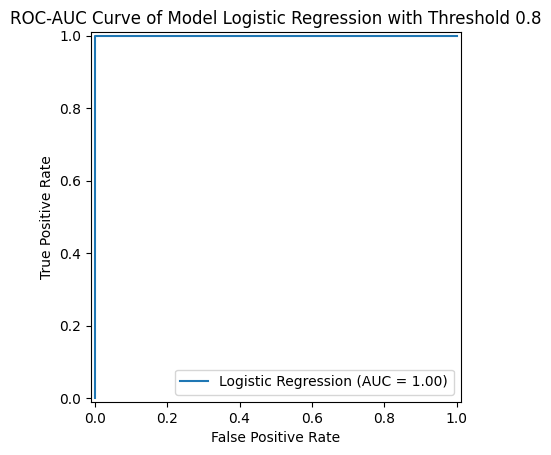

In [57]:
plot_roc_auc(y_test, probs_lr,0.8,"Logistic Regression", )

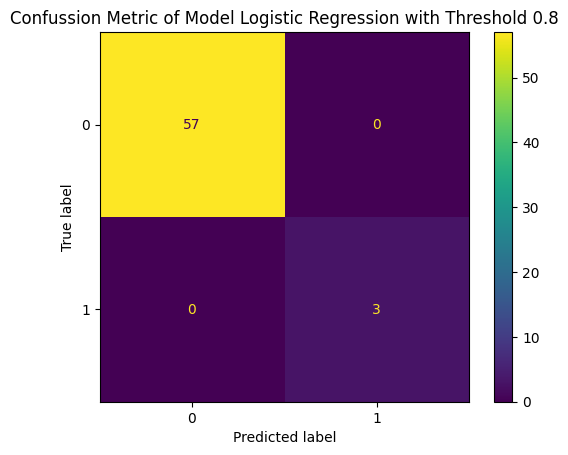

In [58]:
plot_confussion_metric(y_test, probs_lr,0.8,"Logistic Regression" )

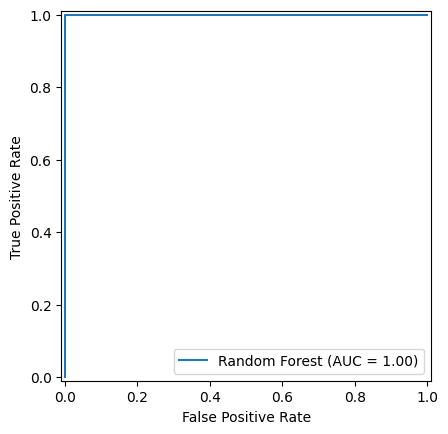

In [45]:
plot_roc_auc(y_test, probs_rf,0.2,"Random Forest" )

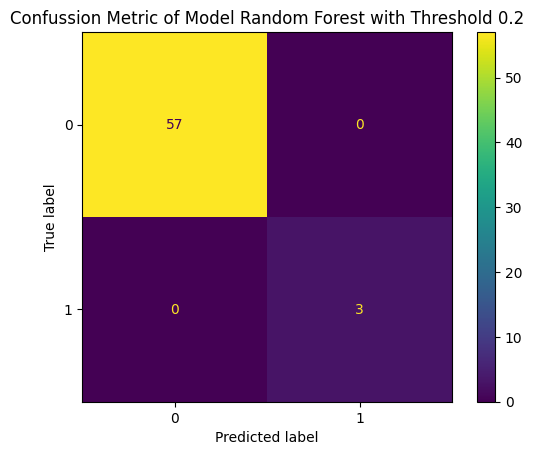

In [59]:
plot_confussion_metric(y_test, probs_rf,0.2,"Random Forest" )

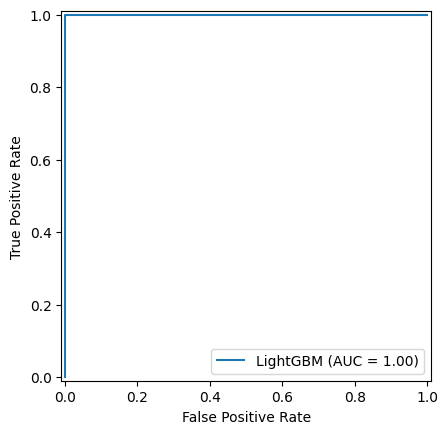

In [46]:
plot_roc_auc(y_test, probs_lgbm,0.75,"LightGBM" )

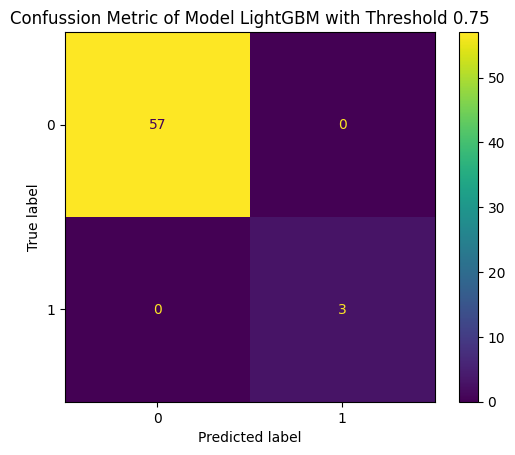

In [60]:
plot_confussion_metric(y_test, probs_lgbm,0.75,"LightGBM" )

In [31]:
joblib.dump(lgbm_clf, '../artifact/lightgbm_model.pkl')

['../artifact/lightgbm_model.pkl']